# Project 2 - WIP

**What:** Estimate the share of residents within an ~800m (~0.5mi) walk of a park.   Instead of Distance, use travel time

**Data:** City parks (open data), Census tracts + ACS population (TIGER/ACS).

**Method:**
- Buffer parks (800 m) → sjoin with tracts to get park-buffer area per tract.
- Create Walk-time settings
- Aggregate: park-buffer area ÷ tract area; optionally weight by pop.
- Filter: flag tracts < X% access.
- Map: Isochrone (area accessible from a point within a certain time threshold) of % population/area with park access; label lowest-access tracts.


Data:
County Boundary Layer (EPSG: 4269): https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_county_500k.zip
Census Tracts Layer (EPSG: 4269): https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_tract_500k.zip
ACS (API): https://api.census.gov/data/{year}/acs/acs5   {year} is a parameter in the code. Makes code a little more extensible. 2023 is the latest So that is what is used.

Cannot find ACS (American Community Survey) data download, so API will be used unless I can find a file download.
API key acquired.  Might be able to use this: https://www.arcgis.com/home/item.html?id=f430d25bf03744edbb1579e18c4bf6b8


import requests for pulling ACS data table

Missoula County FIPS: 30063


Total population from ACS shown in Table B01003, ref. https://censusreporter.org/tables/B01003/


Map from initial data exploration, using Missoula County as a test for census tracts and admin boundaries

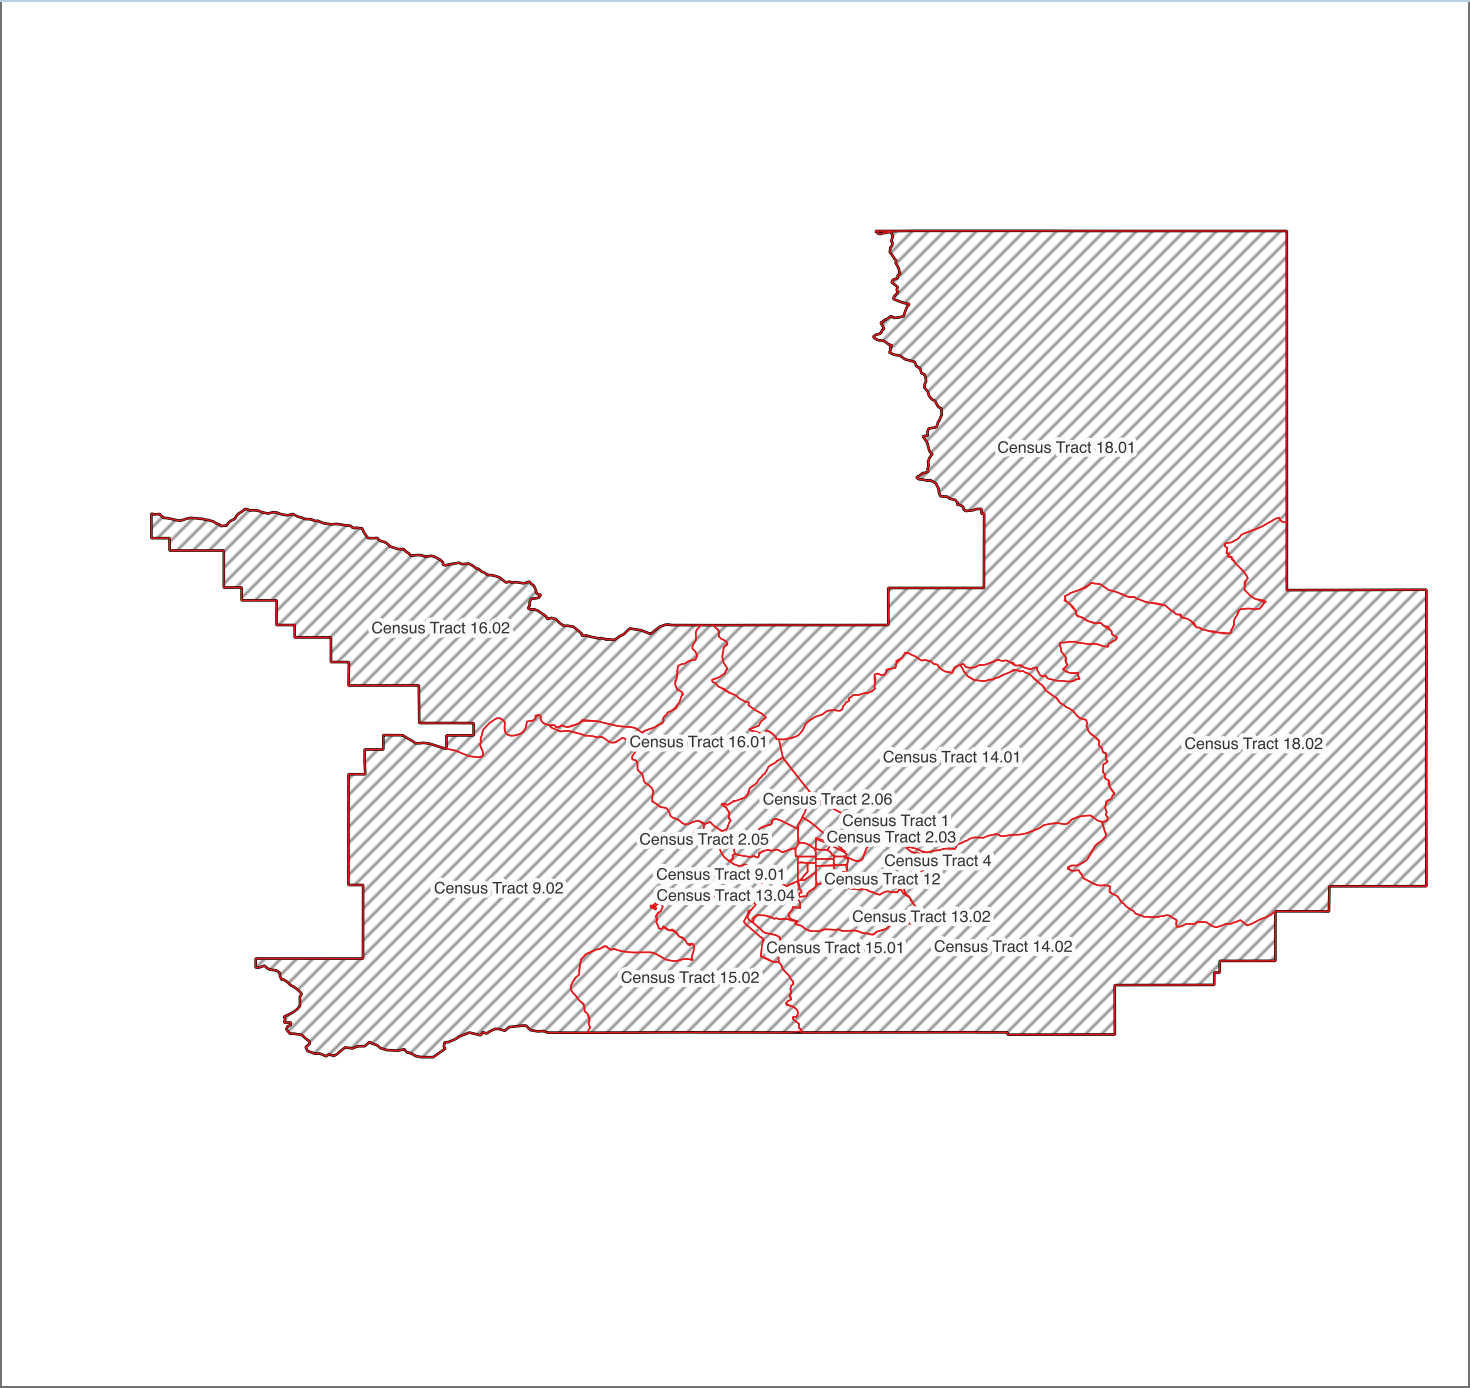


Use .env for ACS API key; this keeps key local and secure

## CODE Begin

### Module imports

In [1]:
import os
import io
import zipfile
import tempfile
import geopandas as gpd
import pandas as pd
import osmnx as ox
import requests
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt


import contextily as cx


### Set parameters

Using .env file to store Census API. This keeps API key private,

Average walking speed 3-4 mph (4.8km/h) https://www.healthline.com/health/exercise-fitness/average-walking-speed



In [2]:
# Tracts zip file path
tracts_zip = "data/cb_2023_us_tract_500k.zip"

# Counties zip file path
counties_zip = "data/cb_2023_us_county_500k.zip"

# Need to find CRS for region used - for measuring distance
crs = 4326


# State FIPS for tests: Montana (30), California (06), Illinois (17), NM (35)

city = "Missoula"
state = "MT"
state_fips = "30"
acs_year = 2023  # ACS 5-year
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY") # signed up on census.gov


Settings for isochrone - walk times and speed

In [3]:
iso_minutes = 10
walk_kph = 4.8


Function to unzip and read zipped files into tempfile. This is specifically looking for .shp

In [4]:
def read_zipped_file(zip_path):
    """Read zipped file into tempfile"""
    with zipfile.ZipFile(zip_path) as z, tempfile.TemporaryDirectory() as tmpdir:
        z.extractall(tmpdir)
        shp_rel = [n for n in z.namelist() if n.lower().endswith(".shp")][0]
        shp_path = os.path.join(tmpdir, shp_rel)
        return gpd.read_file(shp_path)

Get "place" boundary as **aoi**
- ox.geocode_to_gdf(f"{city}, {state}, USA") queries OSM for that place. Usually returns city boundaries, but depends on location

Using counties boundaries to clip census tracts simplifies the dataset and also allows use for cities that are in multiple counties.

Call function to read zip files

In [5]:
print(crs)

# fetch OSM place and set AOI to city boundaries, set CRS to above
aoi = ox.geocode_to_gdf(f"{city}, {state}, USA")[["geometry"]].to_crs(crs)

4326


Read the files

In [6]:
# testing CRS stuff
# tracts = read_zipped_file(tracts_zip)
# counties = read_zipped_file(counties_zip)
tracts = read_zipped_file(tracts_zip).to_crs(crs)
counties = read_zipped_file(counties_zip).to_crs(crs)

Clip to city boundaries, get county fips

In [7]:
# These clip tracts and county to aoi (city boundaries) using intersection
tracts_aoi = gpd.overlay(tracts, aoi, how="intersection", keep_geom_type=False)
counties_aoi = gpd.overlay(counties, aoi, how="intersection", keep_geom_type=False)

# Making list of county fips from aoi. This allows it to work when city is in multiple counties
county_fips = counties_aoi["GEOID"].str[-3:].unique().tolist()

###############
# Sanity checks
print("Tracts CRS:", tracts.crs)
print("Counties CRS:", counties.crs)

print("Tracts AOI CRS:", tracts_aoi.crs)
print("Counties AOI CRS:", counties_aoi.crs)


print("TRACTS \n", tracts.head(10))
print("COUNTIES \n", counties.head(10))

# check that this returns poly/mulitpoly and not point
print(f"AOI geometyry type: {aoi.geom_type.iloc[0]}")


print("County FIPS in AOI:", county_fips)
print("Tracts in AOI:", len(tracts_aoi))


Tracts CRS: epsg:4326
Counties CRS: epsg:4326
Tracts AOI CRS: epsg:4326
Counties AOI CRS: epsg:4326
TRACTS 
   STATEFP COUNTYFP TRACTCE               GEOIDFQ        GEOID    NAME  \
0      06      077  005127  1400000US06077005127  06077005127   51.27   
1      06      077  003406  1400000US06077003406  06077003406   34.06   
2      06      077  004402  1400000US06077004402  06077004402   44.02   
3      06      077  001700  1400000US06077001700  06077001700      17   
4      06      077  000401  1400000US06077000401  06077000401    4.01   
5      06      077  003404  1400000US06077003404  06077003404   34.04   
6      37      037  020600  1400000US37037020600  37037020600     206   
7      37      105  030102  1400000US37105030102  37105030102  301.02   
8      37      165  010300  1400000US37165010300  37165010300     103   
9      05      107  480500  1400000US05107480500  05107480500    4805   

              NAMELSAD STUSPS          NAMELSADCO      STATE_NAME LSAD  \
0   Census Tr

Function to pull ACS pop. data


For total pop
Total population shown in Table B01003, ref. https://censusreporter.org/tables/B01003/

https://api.census.gov/data/2023/acs/acs5/variables.html

In [8]:
# ToDo:
# ACS URL should be: "https://api.census.gov/data/<YEAR>/acs/acs5"
# parmeterize {year} for extensibility

def acs_tract_population(state_fips, county_fips, year=2023, api_key=None):
    """
    Parameters:
    state_fips: 2-digit state_fips (MT = "30")
    county_fips: a list of (3 digit) county FIPS codes pulled from (MSO = "063")
    acs_year: the ACS vintage (2023).
    
    B01003_001E (Total Pop) for tracts
    """
    base_url = f"https://api.census.gov/data/{acs_year}/acs/acs5"
    # empty list to store pop. data based on FIPS of AOI
    rows = []
    
    for cf in county_fips:
        params = {
            "get": "B01003_001E,NAME",
            "for": "tract:*",
            "in":  f"state:{state_fips} county:{cf}"
        }

        params["key"] = api_key
        r = requests.get(base_url, params=params, timeout=60)
        r.raise_for_status()
        data = r.json()
        cols = data[0]
        for rec in data[1:]:
            rows.append(dict(zip(cols, rec)))
    print(f"ACS:\n {rows}")
 
    df = pd.DataFrame(rows)
    # create ID (GEOID) for each ACS row - this joins to GEOID in Census Tracts
    df["GEOID"] = df["state"] + df["county"] + df["tract"]
    # convert pop. string to numeric
    df["B01003_001E"] = pd.to_numeric(df["B01003_001E"])
    return df[["GEOID","B01003_001E","NAME","state","county","tract"]]



# Call function to request ACS
acs = acs_tract_population(state_fips, county_fips, acs_year, api_key=CENSUS_API_KEY)
print(f"ACS dataframe:\n {acs}")
# Join ACS to Tracts intersecting AIO
tracts_aoi = tracts_aoi.merge(acs, on="GEOID", how="inner")
print(f"Tracts_aoi Merge:\n {tracts_aoi}")


ACS:
 [{'B01003_001E': '6581', 'NAME': 'Census Tract 1; Missoula County; Montana', 'state': '30', 'county': '063', 'tract': '000100'}, {'B01003_001E': '4568', 'NAME': 'Census Tract 2.03; Missoula County; Montana', 'state': '30', 'county': '063', 'tract': '000203'}, {'B01003_001E': '3331', 'NAME': 'Census Tract 2.04; Missoula County; Montana', 'state': '30', 'county': '063', 'tract': '000204'}, {'B01003_001E': '7573', 'NAME': 'Census Tract 2.05; Missoula County; Montana', 'state': '30', 'county': '063', 'tract': '000205'}, {'B01003_001E': '7649', 'NAME': 'Census Tract 2.06; Missoula County; Montana', 'state': '30', 'county': '063', 'tract': '000206'}, {'B01003_001E': '2315', 'NAME': 'Census Tract 3; Missoula County; Montana', 'state': '30', 'county': '063', 'tract': '000300'}, {'B01003_001E': '2876', 'NAME': 'Census Tract 4; Missoula County; Montana', 'state': '30', 'county': '063', 'tract': '000400'}, {'B01003_001E': '3471', 'NAME': 'Census Tract 5.01; Missoula County; Montana', 'state

## OSM Stuff

Pull parks (polygons) within the city

Walk network for the AOI

Assign travel time (in seconds) to edges using constant walking speed

Tags for parks in OSM:
- https://towardsdatascience.com/fetching-green-areas-from-osm-data-a6ff835c40dc/
- https://wiki.openstreetmap.org/wiki/Key:leisure


Calculating times:
- https://gis.stackexchange.com/questions/448334/how-to-calculate-the-length-and-duration-of-trip-for-a-geodataframe-of-points-on
- https://github.com/eemilhaa/walkability-analysis/blob/main/routing_analysis.ipynb
- https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.speed.add_edge_travel_times
- https://towardsdatascience.com/shortest-path-dijkstras-algorithm-step-by-step-python-guide-896769522752/
- https://www.geeksforgeeks.org/python/find-shortest-path-using-python-osmnx-routing-module/
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.multi_source_dijkstra_path_length.html
- https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html
- https://kuanbutts.com/2017/12/16/osmnx-isochrones/



Generate park polygons

In [9]:
tags = {"leisure": ["park", "nature_reserve", "playground", "garden"]}
# creates gdf of parks within aoi boundaries
parks = ox.geometries_from_polygon(aoi.to_crs(crs).geometry.iloc[0], tags)
# print(f"OSM Parks:\n {parks}")

# set parks crs to match
parks = parks.to_crs(crs)

# restrict geometry to poly/multipoly only - OSM might return points or lines also
# also only keep geometry and leisure columns
parks = parks[parks.geometry.geom_type.isin(["Polygon", "MultiPolygon"])][["geometry", "leisure"]]

# Timings
# ABQ 4m 15.9s
# DB 
# MSO 
#  


Create network

In [10]:
# this builds a path network within the AOI polygon
# the network type is walk (there are others such as drive and bike, etc.)
# gets the first record iloc[0]; used in for loop
GRAPH = ox.graph_from_polygon(aoi.geometry.iloc[0], network_type="walk", simplify=False)


########
# Sanity cehck
# nodes, edges = ox.graph_to_gdfs(GRAPH)
# print(f"edges:\n {edges}")
# print(f"nodes:\n {nodes}")
########


# Timings
# ABQ 9m 12.3s
# DB 
# MSO 
#  


Get edges and calc travel time

In [11]:
# OSM graph lengths are in meters; convert kph to m/s
speed_mps = walk_kph * 1000 / 3600.0

# iterate over all edges in graph
# there can be parallel edges between the same two nodes; keys=True returns a unique key per edge; I don't know how this affects anything, so leaving as TRUE (more research)
# underscores let u, v, key to be ignored
# d is the edge attribute dict - where length is stored
# add "travel_time" to GDF
for _, _, _, d in GRAPH.edges(keys=True, data=True):
    length_m = d.get("length", 0.0)
    d["travel_time"] = length_m / speed_mps

Get park points

In [12]:
# get point for each park. representative_point() is always inside - centroid, not so much
# for each park point long/lat, finds the nearest node in graph (graph contains the "edges")
# uses Dijkstra's shortest path method; generates origin points (graph nodes closest to each park point) for each 
park_pts = parks.geometry.representative_point()
# print(f"park points: {park_pts}")
sources = [ox.distance.nearest_nodes(GRAPH, x, y) for x, y in zip(park_pts.x, park_pts.y)]

# Timings
# ABQ 29m 27.8s
# DB 
# MSO 
# 

Generate shortest times

In [13]:
# runs multi-source Dijkstra on "walk" network and returns shortest time in graph from a given set of source nodes
# returns a dict mapping node_id -> min_time_seconds
# for every node it picks the shortest time path from the nearest source
times = nx.multi_source_dijkstra_path_length(GRAPH, sources, weight="travel_time")
# print(times)

Creat subgraph with only edges and nodes within time

In [14]:
# because the above returns seconds, convert iso_minutes to seconds
T = iso_minutes * 60
# generate a list of keys from "times" where  values are less than T
nodes_within = [n for n, t in times.items() if t <= T]
# make subgraph: basically a filtered version of GRAPH, keeping only edges and the nodes that are within the time threshold
SG = GRAPH.subgraph(nodes_within).copy()

# convert subgraph "SG" to gdf
# nodes=False     don't need points, edges have lengths
# fill_edge_geometry=True     each edge has its full geometry, not just a straight line between nodes
edges = ox.utils_graph.graph_to_gdfs(SG, nodes=False, fill_edge_geometry=True)

Prep isochrone data Pt 1

In [15]:
# Geopandas can estiamte a local CRS (UTM) using pyproj
# Cannot use 4326 because creating buffer needs projected CRS
area_crs = edges.estimate_utm_crs()

# Reproject edges to meters based CRS; all OSM data is already meters
edges_m = edges.to_crs(area_crs)


# prefix "iso" is for code that directly relates to the map (isochrone)
# edges_m is line geometry
# create a 25m buffer on edges_m
# unary_union does a dissolve on edges_m and the buffer creating a polygon
edge_buffer_m = 25
iso_poly_m = edges_m.buffer(edge_buffer_m).unary_union

# gdf to populate - should be single record/row
isochrone_gdf = gpd.GeoDataFrame(geometry=[iso_poly_m], crs=area_crs)
print(f"isochrone_gdf: {isochrone_gdf}")


isochrone_gdf:                                             geometry
0  MULTIPOLYGON (((724257.059 5186976.034, 724254...


Prep isochrone data Pt 2

In [16]:
# set CRS and calc area of tracts (sq. meters)
tracts_m = tracts_aoi.to_crs(area_crs).copy()
tracts_m["tract_area_m2"] = tracts_m.geometry.area

# intersect tracts with isochrone gdf polygons, measure overlap
# quantifies how much of each tract lies within walking time distance
# add column "inter_area_m2" to gdf with results
tr_iso_inter = gpd.overlay(tracts_m, isochrone_gdf, how="intersection")
tr_iso_inter["inter_area_m2"] = tr_iso_inter.geometry.area

# sum intersected pieces by tract and merge sum to all tracts, no overlap = NaN
# fillna(0) turns NaN to zero
inter_sums = tr_iso_inter.groupby("GEOID", as_index=False)["inter_area_m2"].sum()
tracts_m = tracts_m.merge(inter_sums, on="GEOID", how="left")
tracts_m["inter_area_m2"] = tracts_m["inter_area_m2"].fillna(0)
tracts_m["pop_total"] = tracts_m["B01003_001E"].fillna(0)

print(f"tracts_m: {tracts_m}")

#calc area of tract (or part of tract) that falls within isochrone
# clip keeps fraction positive, thanks python maths issues
tract_fraction = (tracts_m["inter_area_m2"] / tracts_m["tract_area_m2"]).clip(0,1)
# area weighted pop. whithin isochrone, save to new column
tracts_m["pop_near_park"] = tracts_m["pop_total"] * tract_fraction

# convert to percent of tract pop
tracts_m["pct_access"] = (100 * tracts_m["pop_near_park"] / tracts_m["pop_total"])


tracts_m:    STATEFP COUNTYFP TRACTCE               GEOIDFQ        GEOID NAME_x  \
0       30      063  000100  1400000US30063000100  30063000100      1   
1       30      063  000802  1400000US30063000802  30063000802   8.02   
2       30      063  001200  1400000US30063001200  30063001200     12   
3       30      063  001002  1400000US30063001002  30063001002  10.02   
4       30      063  000502  1400000US30063000502  30063000502   5.02   
5       30      063  000300  1400000US30063000300  30063000300      3   
6       30      063  001001  1400000US30063001001  30063001001  10.01   
7       30      063  000203  1400000US30063000203  30063000203   2.03   
8       30      063  001402  1400000US30063001402  30063001402  14.02   
9       30      063  001601  1400000US30063001601  30063001601  16.01   
10      30      063  001100  1400000US30063001100  30063001100     11   
11      30      063  001303  1400000US30063001303  30063001303  13.03   
12      30      063  001304  1400000US300

# Let's Make a Map!

tracts_plot empty? False rows: 23


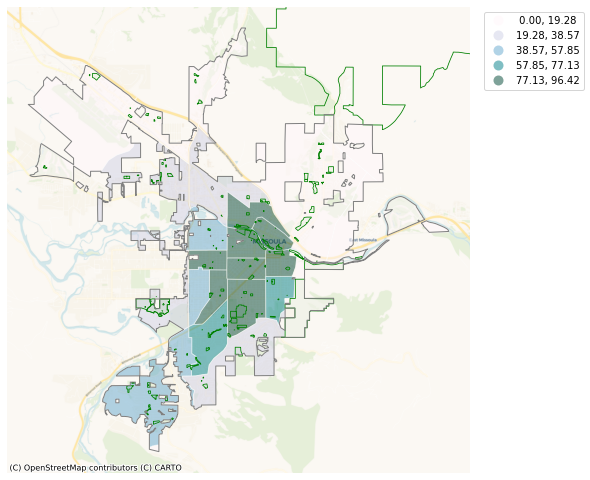

In [ ]:
# set CRS for map, need 3857 for contextily
plot_crs = 3857

# set everything to same CRS
# pct_access lives on tracts_m
# make copy of tracts_m with only pct_access and geom; smaller dataset
tracts_plot = tracts_m.to_crs(plot_crs)[["pct_access","geometry"]].copy()
isochrone_plot = isochrone_gdf.to_crs(plot_crs)
parks_plot = parks.to_crs(plot_crs)


# sanity check
print("tracts_plot empty?", tracts_plot.empty, "rows:", len(tracts_plot))

# create matplotlib figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# make the map
# using equal intervals (vs quantiles) as this makes comaprisons against other cities easier
# use this?? scheme = "user_defined", classification_kwds={"bins":[20,40,60,80,100]} 
tracts_plot.plot(
    column="pct_access",
    scheme="equal_interval", k=5,
    cmap="PuBuGn",
    linewidth=0.9, edgecolor="white",
    legend=True,
    legend_kwds={"loc": "upper left", "bbox_to_anchor": (1.02, 1), "frameon": True},
    ax=ax, alpha=0.5,
)

# add basemap to isochrone
cx.add_basemap(ax, crs=plot_crs, source=cx.providers.CartoDB.Voyager)

# city boundary
aoi_plot = aoi.to_crs(plot_crs)
aoi_plot.boundary.plot(ax=ax, color="grey", linewidth=1, zorder=5)


# put park boundaries on top
parks_plot.boundary.plot(ax=ax, linewidth=0.8, color="green", zorder=3)

# turn off x/y coords
ax.set_axis_off()

plt.tight_layout(rect=(0, 0, 0.82, 1)) 
plt.show()

